In [1]:
# =========================
# Import Libraries
# =========================

import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [2]:
# =========================
# Read CSV File
# =========================

df = pd.read_csv('../data/at-dataset/SCATS-data/Scats-Data-Processed.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

le = LabelEncoder()
df['Direction'] = le.fit_transform(df['Direction'])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [5]:
# =========================
# Sample of DF
# =========================

df.head(5)

,Detector_ID,Lane,Volume,Direction
DateTime,,,,
2023-01-01 00:00:00,2001,1,31,0
2023-01-01 01:00:00,2001,1,47,0
2023-01-01 02:00:00,2001,1,61,0
2023-01-01 03:00:00,2001,1,37,0
2023-01-01 04:00:00,2001,1,33,0


In [6]:
# =========================
# Column Info
# =========================

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7863406 entries, 2023-01-01 00:00:00 to 2025-07-31 23:00:00
Data columns (total 4 columns):
 #   Column       Dtype
---  ------       -----
 0   Detector_ID  int64
 1   Lane         int64
 2   Volume       int64
 3   Direction    int64
dtypes: int64(4)
memory usage: 300.0 MB


In [7]:
# =========================
# Functions for plotting traffic volume for each lane
# =========================

def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

# =========================
# Functions for plotting traffic volume for each lane for one week
# =========================

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

In [8]:
# =========================
# Set sub_df for training and testing
# =========================

sub_df = df
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']

In [10]:
# =========================
# Functions for Feature Creation
# =========================

def create_time_features(df):
    df = df.copy().sort_index()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # # cyclical encodings
    # df["sin_hour"] = np.sin(2*np.pi*df["hour"]/24)
    # df["cos_hour"] = np.cos(2*np.pi*df["hour"]/24)
    # df["sin_dow"]  = np.sin(2*np.pi*df["dayofweek"]/7)
    # df["cos_dow"]  = np.cos(2*np.pi*df["dayofweek"]/7)

    # # ---- LAGS (hourly)
    # # short-term: 1–12h, daily pattern: 24–25h, multi-day & weekly: 48–168h
    # lags = [1, 2, 3, 6, 12, 24, 25, 48, 72, 168]
    # for L in lags:
    #     df[f"lag_{L}"] = df['Volume'].shift(L)

    # # ---- ROLLING STATS (use shift(1) to avoid leakage)
    # # 3h, 6h, 12h, 24h (1d), 168h (1w)
    # wins = {"3h":3, "6h":6, "12h":12, "1d":24, "1w":168}
    # for name, w in wins.items():
    #     past = df['Volume'].shift(1)
    #     df[f"roll_mean_{name}"] = past.rolling(w).mean()
    #     df[f"roll_max_{name}"]  = past.rolling(w).max()
    #     df[f"roll_std_{name}"]  = past.rolling(w).std()

    return df

In [11]:
# =========================
# Create time features
# =========================

sub_df = create_time_features(sub_df)
train = create_time_features(train)
test  = create_time_features(test)
train = train.dropna()
FEATURES = [
    "Detector_ID","Lane","hour","day","dayofweek","month","year","is_weekend","Direction"
    # "sin_hour","cos_hour","sin_dow","cos_dow",
    # "lag_1","lag_2","lag_3","lag_6","lag_12","lag_24","lag_25","lag_48","lag_72","lag_168",
    # "roll_mean_3h","roll_mean_6h","roll_mean_12h","roll_mean_1d","roll_mean_1w",
    # "roll_max_3h","roll_std_3h"
]
TARGET = 'Volume'

In [13]:
# =========================
# Split data into X and y
# =========================

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [14]:
# =========================
# Check info of X_train
# =========================

X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5343718 entries, 2023-01-01 00:00:00 to 2024-09-30 23:00:00
Data columns (total 9 columns):
 #   Column       Dtype
---  ------       -----
 0   Detector_ID  int64
 1   Lane         int64
 2   hour         int32
 3   day          int32
 4   dayofweek    int32
 5   month        int32
 6   year         int32
 7   is_weekend   int64
 8   Direction    int64
dtypes: int32(5), int64(4)
memory usage: 305.8 MB


In [15]:
# =========================
# Model Training with XGBoost
# =========================

reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",            # or "gpu_hist"
    max_depth=8,
    learning_rate=0.05,
    n_estimators=3000,             # high cap; early stopping trims it
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.2,
    reg_alpha=0.0,
    reg_lambda=2.0,
    random_state=42,
    early_stopping_rounds=50,
    enable_categorical=True,     # uncomment if you cast IDs to category & have new XGB
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric="rmse",
    verbose=100
)
reg.save_model('../models/xgb-model-v2w.json')

[0]	validation_0-rmse:98.83557	validation_1-rmse:102.91199
[100]	validation_0-rmse:61.21124	validation_1-rmse:68.13858
[200]	validation_0-rmse:50.35838	validation_1-rmse:60.25162
[300]	validation_0-rmse:45.49031	validation_1-rmse:57.00154
[400]	validation_0-rmse:42.04224	validation_1-rmse:54.83690
[500]	validation_0-rmse:40.15856	validation_1-rmse:53.98811
[600]	validation_0-rmse:38.44372	validation_1-rmse:53.05464
[700]	validation_0-rmse:37.38546	validation_1-rmse:52.71435
[800]	validation_0-rmse:36.44395	validation_1-rmse:52.42064
[900]	validation_0-rmse:35.70229	validation_1-rmse:52.20673
[1000]	validation_0-rmse:35.07027	validation_1-rmse:52.00903
[1100]	validation_0-rmse:34.43629	validation_1-rmse:51.84943
[1200]	validation_0-rmse:33.92655	validation_1-rmse:51.72823
[1300]	validation_0-rmse:33.47236	validation_1-rmse:51.64364
[1400]	validation_0-rmse:33.04700	validation_1-rmse:51.57360
[1500]	validation_0-rmse:32.70341	validation_1-rmse:51.54641
[1600]	validation_0-rmse:32.41470	v

In [16]:
# =========================
# Feature Importance of the Model
# =========================

# reg = xgb.XGBRegressor().load_model('../models/xgb-model.json')
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_).sort_values(by=0, ascending=False)

,0
Detector_ID,0.229340
hour,0.216238
Lane,0.193287
Direction,0.158523
is_weekend,0.073901
dayofweek,0.048809
year,0.041884
month,0.022923
day,0.015094


In [17]:
# =========================
# Make prediction on the test set
# =========================

test['prediction'] = reg.predict(X_test)

In [18]:
# =========================
# Merge prediction with sub_df
# =========================

prediction_df = sub_df.merge(test[['Detector_ID','Lane', 'prediction']], how='left', left_on=['Detector_ID','Lane', sub_df.index], right_on=['Detector_ID','Lane', test.index])
prediction_df.set_index('key_2', inplace=True)
prediction_df.index.name = 'DateTime'

In [19]:
# =========================
# Function for plotting traffic volume with predictions for one week
# =========================

def showTrafficVolumeWithPredictions(df, detector_id, lane):

    start_date = '2025-07-01'
    end_date = '2025-07-08'

    df = df[(df.index > start_date) & (df.index <= end_date) & (df['Lane'] == lane) & (df['Detector_ID'] == detector_id)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Site {detector_id} - Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

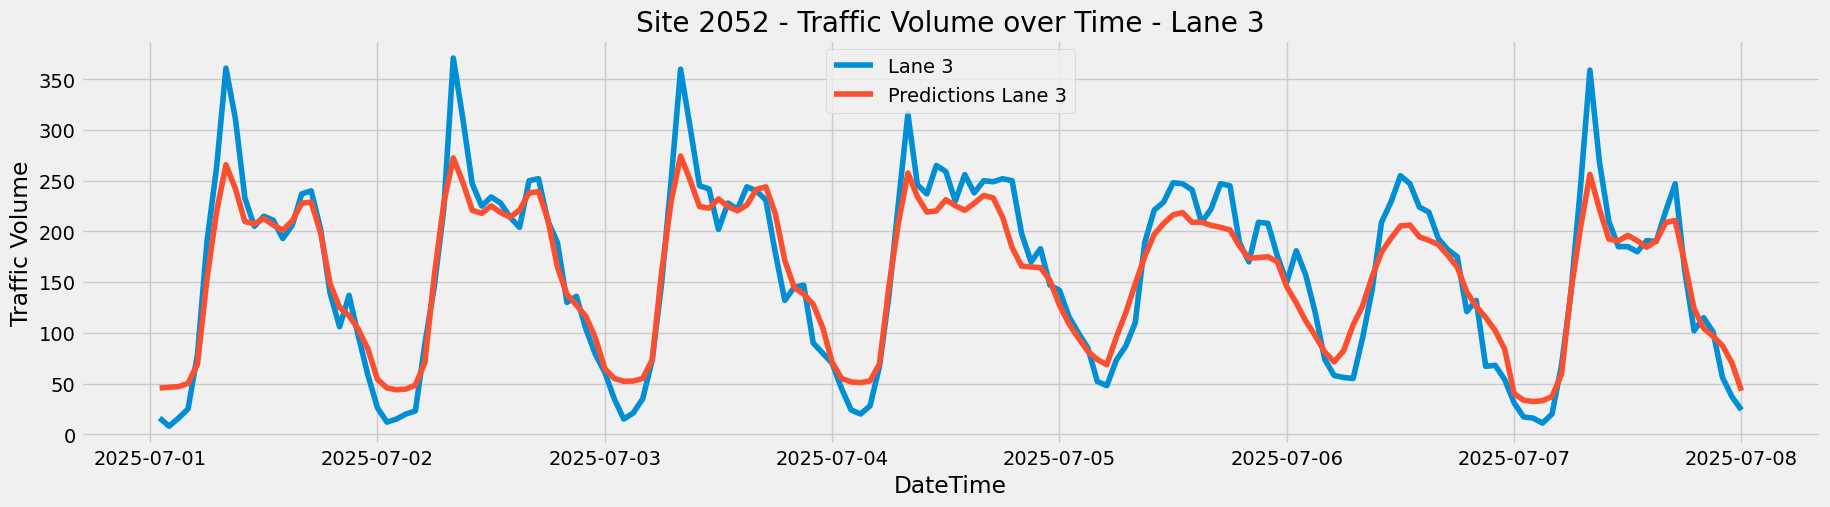

In [20]:
# =========================
# show traffic volume with predictions for one week
# =========================

showTrafficVolumeWithPredictions(prediction_df,2052,3)

In [21]:
# =========================
# Average traffic volume and predictions across all lanes
# =========================

average_traffic = pd.DataFrame()
average_traffic['average_volume'] = prediction_df.groupby(prediction_df.index).mean()['Volume']
average_traffic['average_prediction'] =prediction_df.groupby(prediction_df.index).mean()['prediction']

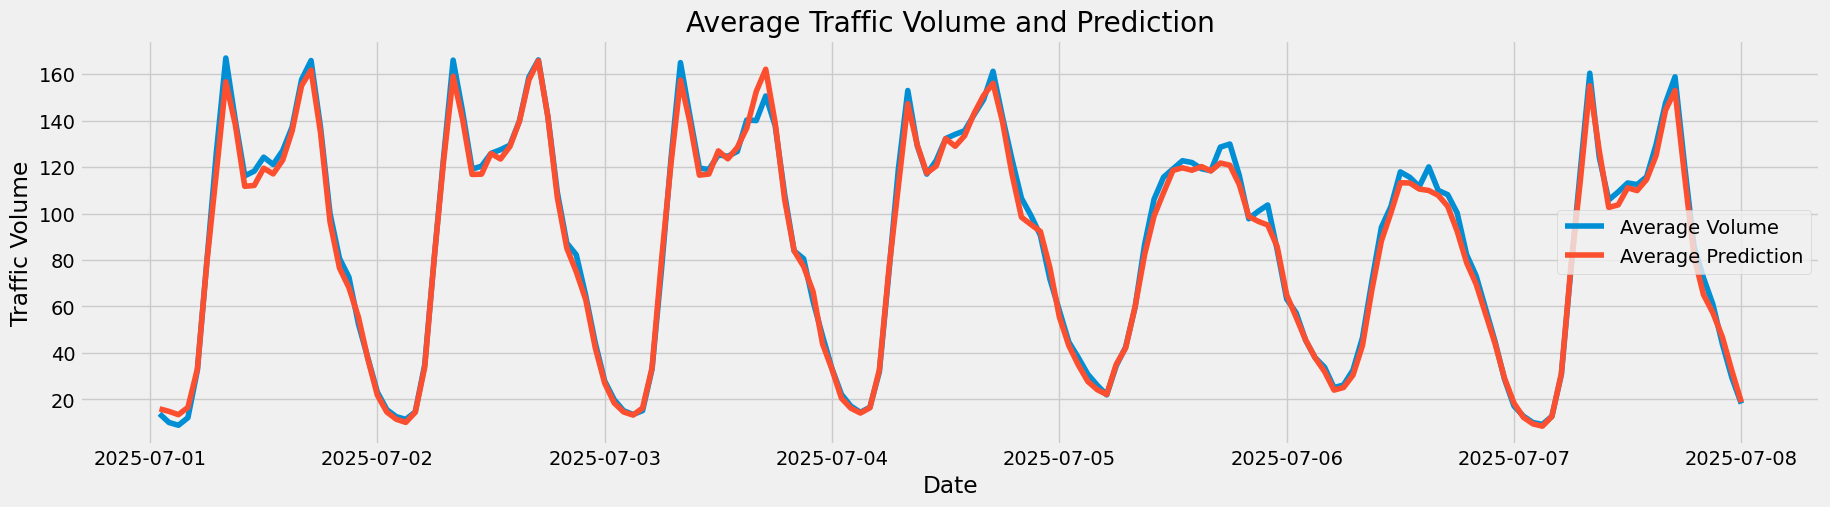

In [22]:
# =========================
# Plot average traffic volume and predictions for one week
# =========================

temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [24]:
# =========================
# Import for SHAP 
# =========================

import shap
# import tqdm as notebook_tqdm

In [25]:
# =========================
# create SHAP explainer
# =========================

background = X_train.sample(min(1000, len(X_train)), random_state=42)
explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

# choose a set to explain
X_explain = X_test  # or X_test

# for speed on big sets, sample
X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain_sample)
# Expected value (model base value)
base_value = explainer.expected_value

In [26]:
# =========================
# Base Value of the Model
# =========================

print("Base value:", explainer.expected_value)

Base value: 87.642715


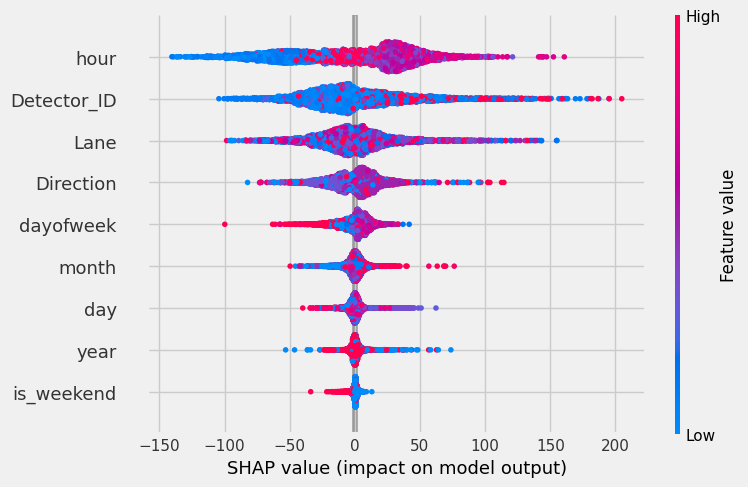

In [27]:
# =========================
# SHAP summary plot
# =========================

shap.summary_plot(shap_values, X_explain_sample, show=True)

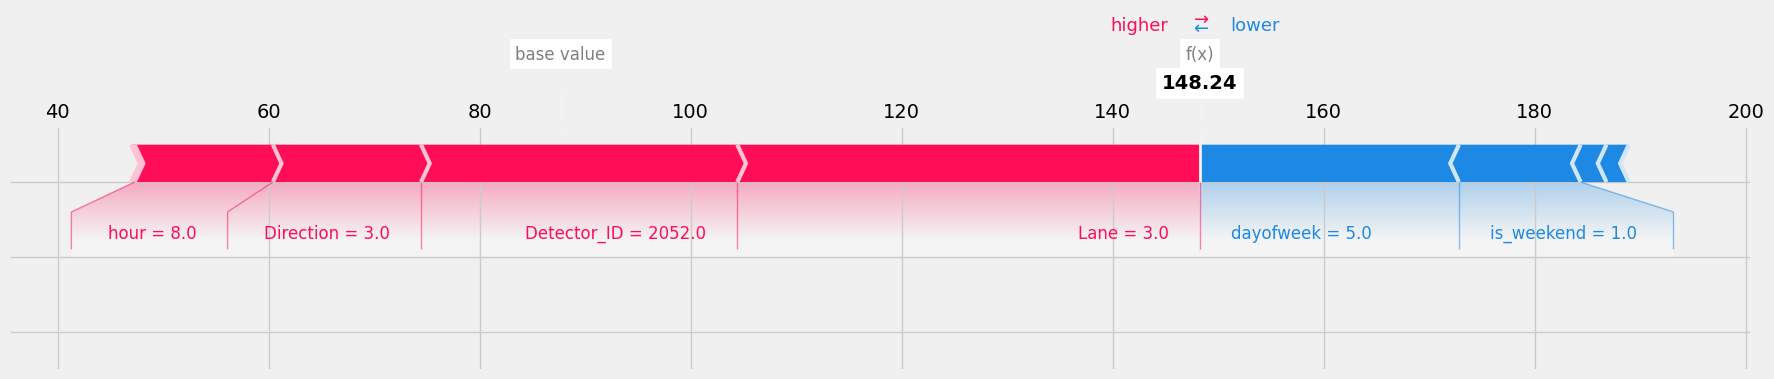

In [28]:
row = X_explain[(X_explain['Lane'] == 3) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

# row = row[selected_features]

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

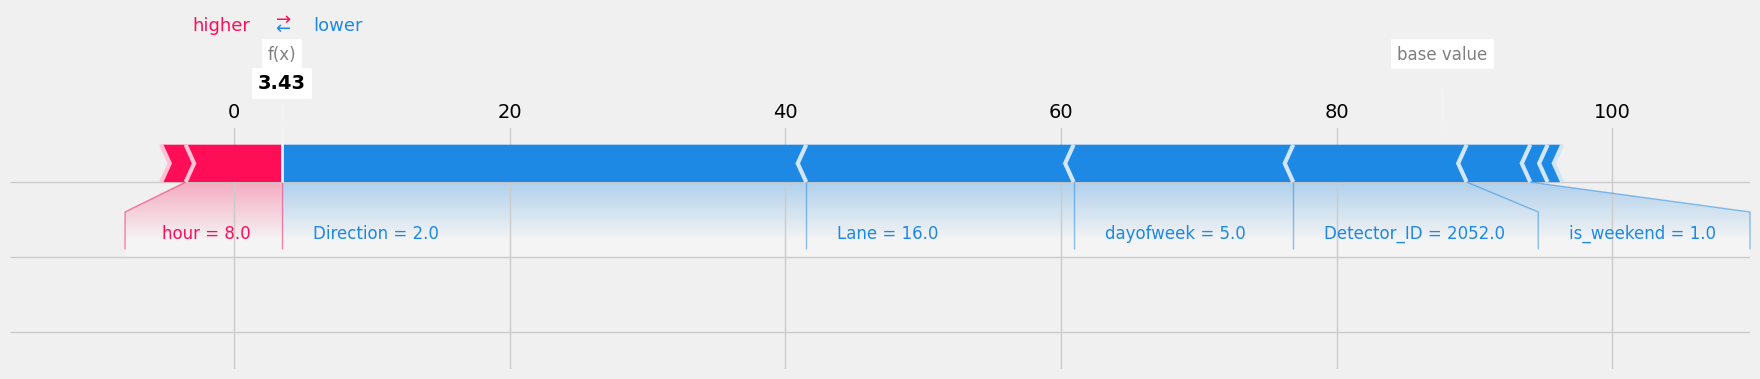

In [29]:
row = X_explain[(X_explain['Lane'] == 16) & (X_explain.index == '2025-07-05 08:00:00') & (X_explain['Detector_ID'] == 2052)]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [30]:
test[(test['Lane'] == 3) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,Direction,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,,
2025-07-05 08:00:00,2052,3,110,3,8,5,5,7,2025,1,148.236221


In [31]:
test[(test['Lane'] == 16) & (test.index == '2025-07-05 08:00:00') & (test['Detector_ID'] == 2052)]

,Detector_ID,Lane,Volume,Direction,hour,day,dayofweek,month,year,is_weekend,prediction
DateTime,,,,,,,,,,,
2025-07-05 08:00:00,2052,16,8,2,8,5,5,7,2025,1,3.427979
